In [1]:
!pip install tensorflow  tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteAX794L/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteAX794L/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## 2. Viz data and build dataset

In [5]:
import numpy as np

# set up connection aka iterator
dataiterator = ds.as_numpy_iterator()
# getting data out of pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

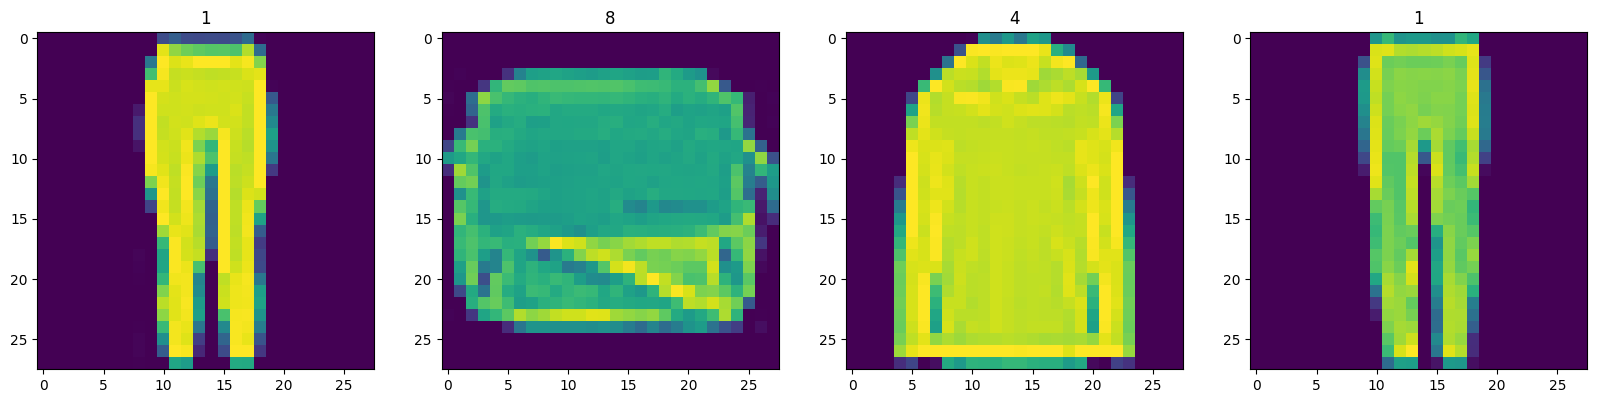

In [6]:
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  #grab an image and label
  sample = dataiterator.next()
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # appending the image label as the plot title
  ax[idx].title.set_text(sample['label'])

In [7]:
# scale and return images only
def scale_images(data):
  image = data['image']
  return image / 255

In [8]:
ds = tfds.load('fashion_mnist', split='train')
# running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# reduce the liklihood of bottlencking
ds = ds.prefetch(64)

In [9]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build the Neural Network

### 3.1 Import modelling components

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build generator

In [11]:
from keras.src.metrics.confusion_metrics import activations
def build_generator():
  model = Sequential()

  # takes in random values and reshapes it to 7x7x128
  #beginnings of a renerated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # conv layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))


  return model

In [12]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [13]:
img = generator.predict(np.random.randn(4, 128,  1))
img

1/1 [==============================] - 7s 7s/step


array([[[[0.4978609 ],
         [0.49660218],
         [0.49888164],
         ...,
         [0.49695456],
         [0.49684513],
         [0.4947476 ]],

        [[0.4936659 ],
         [0.48928714],
         [0.48803124],
         ...,
         [0.49961525],
         [0.5001251 ],
         [0.4971839 ]],

        [[0.49286884],
         [0.48600665],
         [0.5016449 ],
         ...,
         [0.5007528 ],
         [0.5024015 ],
         [0.49814937]],

        ...,

        [[0.5024509 ],
         [0.5047266 ],
         [0.50680786],
         ...,
         [0.5018544 ],
         [0.5022003 ],
         [0.4980075 ]],

        [[0.49886462],
         [0.503461  ],
         [0.50736636],
         ...,
         [0.4999721 ],
         [0.50113773],
         [0.5003098 ]],

        [[0.49599078],
         [0.5010091 ],
         [0.5043228 ],
         ...,
         [0.5036657 ],
         [0.5003307 ],
         [0.5008479 ]]],


       [[[0.5122299 ],
         [0.50591516],
         [0.50

In [14]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 22ms/step


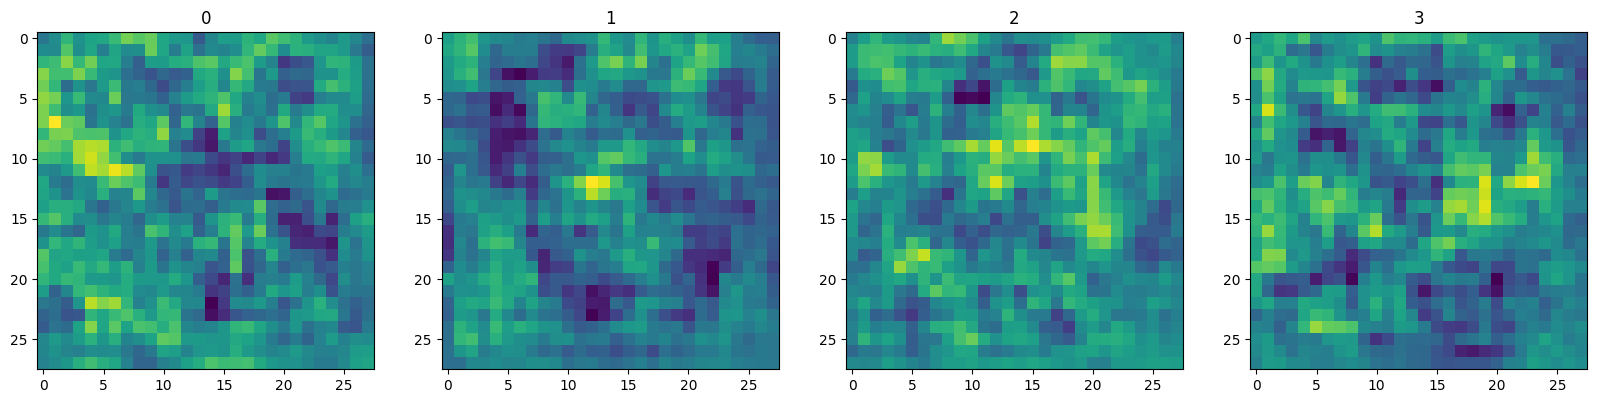

In [15]:
# generate new fashion
img = generator.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(img):
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # appending the image label as the plot title
  ax[idx].title.set_text(idx)

### 3.3 Build discriminator

In [16]:
def build_discriminator():
  model = Sequential()

  # first conv block
  model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # second conv block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # third conv block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # fourth conv block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [17]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [18]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 38ms/step


In [19]:
img.shape

(4, 28, 28, 1)

In [20]:
discriminator.predict(img)

1/1 [==============================] - 0s 314ms/step


array([[0.5035116 ],
       [0.50348425],
       [0.5034957 ],
       [0.5034362 ]], dtype=float32)

In [21]:
img = img[0]
img.shape

(28, 28, 1)

In [22]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 206ms/step


array([[0.50351167]], dtype=float32)

## 4. Construct training loop

### 4.1 Setup losses and optimizers

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [24]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 build subclassed model

In [25]:
# importing the base model calss to subclass our training step
from tensorflow.keras.models import Model

In [26]:
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 1.13301249e-02],
        [-1.68970674e-01],
        [-1.24835290e-01],
        [-4.71939951e-01],
        [-4.48197633e-01],
        [ 7.41898239e-01],
        [ 2.60211349e-01],
        [-4.30939436e-01],
        [ 2.57254422e-01],
        [ 8.06672499e-02],
        [ 2.32741147e-01],
        [-3.36461455e-01],
        [-1.20877874e+00],
        [-2.29734614e-01],
        [ 1.10835266e+00],
        [-1.53839207e+00],
        [-1.54536915e+00],
        [ 6.54097259e-01],
        [-1.35827303e+00],
        [-3.08514237e-01],
        [ 1.34547925e+00],
        [-3.59173119e-01],
        [ 1.57459152e+00],
        [-1.79827392e-01],
        [ 9.36506808e-01],
        [-9.56138730e-01],
        [ 1.92365396e+00],
        [-9.14746225e-01],
        [ 3.25581312e-01],
        [-1.67671204e+00],
        [ 1.52174294e+00],
        [ 1.87217760e+00],
        [ 9.62453842e-01],
        [ 6.75904572e-01],
        [ 2.65684485e+00],
  

In [27]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    # create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # compile with base class
    super().compile(*args, **kwargs)

    # create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    # get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training=False)

    # train the discriminator
    with tf.GradientTape() as d_tape:
      # pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # create labels for real and fake imaged
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # add some noise to the true output
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # calculate loss - BInaryCross
      total_d_loss = self.d_loss(yhat_realfake, yhat_realfake)

    # apply backprppagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


    # train the generator
    with tf.GradientTape() as g_tape:

      # generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # create the predicted labels
      predicted_labels = self.discriminator(gen_images, training=True)

      # calculate loss - trick to training to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss":total_g_loss}

In [28]:
# create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [29]:
# compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build callback

In [30]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [31]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/images/', f'generated_img_{epoch}_{i}.png'))


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filename
checkpoint_path = '/content/generator_weights.h5/'

# Create a ModelCheckpoint callback to save the weights
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',  # Choose a suitable metric to monitor
    mode='min'  # Choose 'min' or 'max' depending on the monitored metric
)

### 4.4 Train

In [33]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor(), checkpoint_callback])

Epoch 1/20
469/469 [==============================] - ETA: 0s - d_loss: 0.0691 - g_loss: 0.0430

469/469 [==============================] - 88s 165ms/step - d_loss: 0.0689 - g_loss: 0.0429
Epoch 2/20
469/469 [==============================] - ETA: 0s - d_loss: 2.6326e-04 - g_loss: 4.8498e-17

469/469 [==============================] - 79s 168ms/step - d_loss: 2.6366e-04 - g_loss: 4.8395e-17
Epoch 3/20
469/469 [==============================] - ETA: 0s - d_loss: 7.3138e-05 - g_loss: 1.0324e-21

469/469 [==============================] - 78s 167ms/step - d_loss: 7.3138e-05 - g_loss: 1.0303e-21
Epoch 4/20
469/469 [==============================] - ETA: 0s - d_loss: 3.1341e-05 - g_loss: 1.2749e-24

469/469 [==============================] - 78s 167ms/step - d_loss: 3.1326e-05 - g_loss: 1.2724e-24
Epoch 5/20
469/469 [==============================] - ETA: 0s - d_loss: 1.5900e-05 - g_loss: 8.7797e-27

469/469 [==============================] - 78s 166ms/step - d_loss: 1.5867e-05 - g_loss: 8.7614e-27
Epoch 6/20
469/469 [==============================] - ETA: 0s - d_loss: 9.1009e-06 - g_loss: 1.4843e-28

469/469 [==============================] - 78s 166ms/step - d_loss: 9.0817e-06 - g_loss: 1.4814e-28
Epoch 7/20
469/469 [==============================] - ETA: 0s - d_loss: 5.5180e-06 - g_loss: 5.9829e-30

469/469 [==============================] - 77s 165ms/step - d_loss: 5.5069e-06 - g_loss: 5.9710e-30
Epoch 8/20
469/469 [==============================] - ETA: 0s - d_loss: 3.6164e-06 - g_loss: 2.7269e-31

469/469 [==============================] - 77s 164ms/step - d_loss: 3.6093e-06 - g_loss: 2.7232e-31
Epoch 9/20
469/469 [==============================] - ETA: 0s - d_loss: 2.1735e-06 - g_loss: 3.5643e-32

469/469 [==============================] - 76s 163ms/step - d_loss: 2.1693e-06 - g_loss: 3.5584e-32
Epoch 10/20
469/469 [==============================] - ETA: 0s - d_loss: 1.4910e-06 - g_loss: 1.4554e-33

469/469 [==============================] - 76s 162ms/step - d_loss: 1.4879e-06 - g_loss: 1.4535e-33
Epoch 11/20
469/469 [==============================] - ETA: 0s - d_loss: 1.1230e-06 - g_loss: 1.7292e-34

469/469 [==============================] - 77s 163ms/step - d_loss: 1.1207e-06 - g_loss: 1.7256e-34
Epoch 12/20
469/469 [==============================] - ETA: 0s - d_loss: 7.4876e-07 - g_loss: 1.3217e-35

469/469 [==============================] - 76s 162ms/step - d_loss: 7.4731e-07 - g_loss: 1.3189e-35
Epoch 13/20
469/469 [==============================] - ETA: 0s - d_loss: 5.8601e-07 - g_loss: 2.3024e-36

469/469 [==============================] - 76s 162ms/step - d_loss: 5.8477e-07 - g_loss: 2.2979e-36
Epoch 14/20
469/469 [==============================] - ETA: 0s - d_loss: 4.3608e-07 - g_loss: 2.5173e-37

469/469 [==============================] - 76s 162ms/step - d_loss: 4.3515e-07 - g_loss: 2.5120e-37
Epoch 15/20
469/469 [==============================] - ETA: 0s - d_loss: 2.8270e-07 - g_loss: 2.3868e-38

469/469 [==============================] - 76s 162ms/step - d_loss: 2.8210e-07 - g_loss: 2.3817e-38
Epoch 16/20
469/469 [==============================] - ETA: 0s - d_loss: 1.9745e-07 - g_loss: 4.0727e-39

469/469 [==============================] - 76s 162ms/step - d_loss: 1.9704e-07 - g_loss: 4.0640e-39
Epoch 17/20
469/469 [==============================] - ETA: 0s - d_loss: 1.6711e-07 - g_loss: 3.3165e-40

469/469 [==============================] - 76s 162ms/step - d_loss: 1.6679e-07 - g_loss: 3.3094e-40
Epoch 18/20
469/469 [==============================] - ETA: 0s - d_loss: 1.0786e-07 - g_loss: 0.0000e+00

469/469 [==============================] - 76s 163ms/step - d_loss: 1.0764e-07 - g_loss: 0.0000e+00
Epoch 19/20
469/469 [==============================] - ETA: 0s - d_loss: 8.9818e-08 - g_loss: 0.0000e+00

469/469 [==============================] - 76s 162ms/step - d_loss: 9.6456e-08 - g_loss: 0.0000e+00
Epoch 20/20
469/469 [==============================] - ETA: 0s - d_loss: 6.8297e-08 - g_loss: 0.0000e+00

469/469 [==============================] - 76s 162ms/step - d_loss: 6.8153e-08 - g_loss: 0.0000e+00


### 4.2 Review the performance

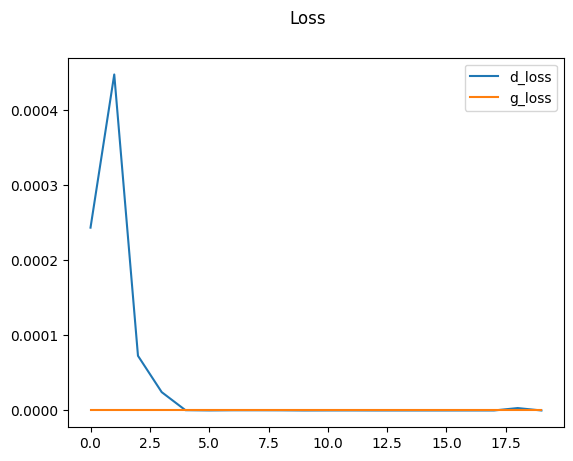

In [34]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## 5. Test out generator

### 5.1 Generate images

In [39]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 1s 684ms/step


In [40]:
img

array([[[0.5008549 ],
        [0.5099414 ],
        [0.5044675 ],
        [0.49870974],
        [0.50021094],
        [0.49479792],
        [0.49640054],
        [0.49200514],
        [0.48941374],
        [0.49379203],
        [0.50533694],
        [0.5179087 ],
        [0.5072    ],
        [0.50911134],
        [0.50435644],
        [0.5010808 ],
        [0.5043785 ],
        [0.49951923],
        [0.5010304 ],
        [0.5018108 ],
        [0.5043179 ],
        [0.5133658 ],
        [0.51162934],
        [0.50406426],
        [0.49661663],
        [0.50097275],
        [0.49577844],
        [0.49260616]],

       [[0.49768382],
        [0.5035717 ],
        [0.500694  ],
        [0.4920609 ],
        [0.4976621 ],
        [0.49313182],
        [0.49623343],
        [0.49295232],
        [0.49215916],
        [0.488732  ],
        [0.49189395],
        [0.5067243 ],
        [0.50171393],
        [0.5090168 ],
        [0.50105304],
        [0.50278294],
        [0.50711346],
        

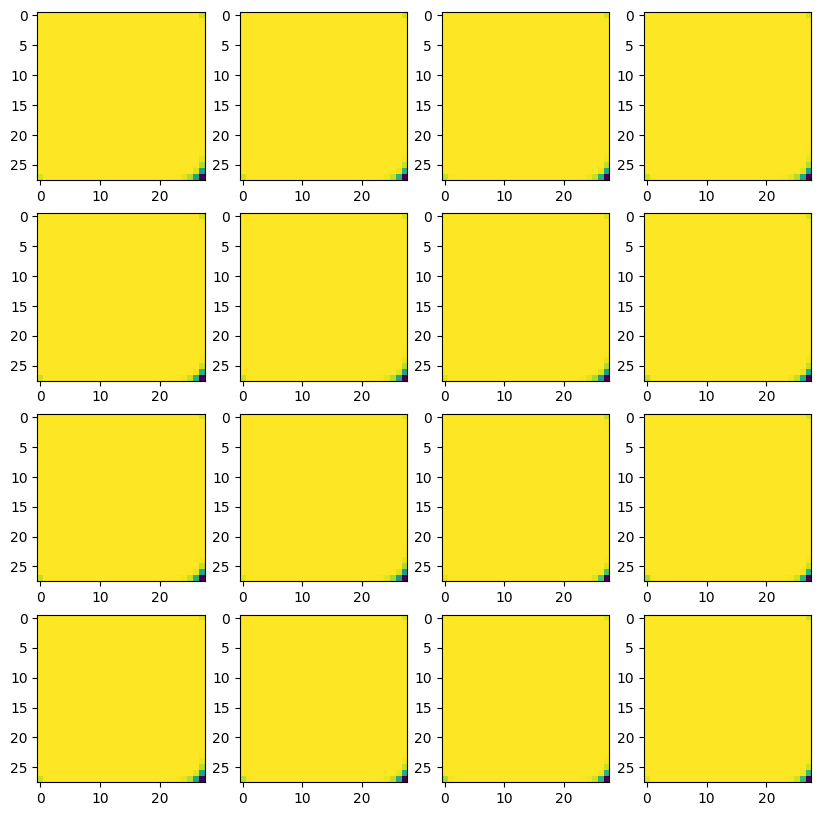

In [41]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])